In [1]:
# equations and such from 1405.7365 for the most part
# some of this will have to be new because there are more restrictions for higher dimensions than paper implies
# more detailed (schizo) comments are left in the PertRNBH before this guy

In [2]:
import sympy as smp
import matplotlib.pyplot as plt
smp.init_printing(use_latex='mathjax')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
import numpy as np
import scipy as sp

In [3]:
# We figured out that the math doesnt suck when we have d = 2, so we'll build and test with this and then introduce the extra cubic cutoff term for d>2

In [4]:
rmax = 1000000000
num = 500

In [5]:
d = 4
k = 0
l = 1
q = 0

In [6]:
# surely there exist EQ numbers for all these in the 14** paper

In [7]:
def mu(R):
    return (R**(d-2))*(k+(q**2)/(R**(2*d-4))+(R**2)/(l**2))

def f(r,R):
    return k - mu(R)/(r**(d-2)) + (q**2)/(r**(2*d-4)) + (r**2)/(l**2)

def fp(r,R):
    return (d-2)*mu(R)/(r**(d-3)) + (4-2*d)*(q**2)/(r**(2*d-5))+ 2*r/(l**2)

def beta(R):
    return 4 * np.pi / fp(R,R)

def gamma2(r0,R):
    return -1*f(r0,R)*(r0**(2*d-4))

In [8]:
def determ(r,R,k=k,q=q,l=l):
    return k*(r**(2*d-4)) - mu(R)*(r**(d-2)) + (q**2) + (r**(2*d-2))/(l**2)

In [9]:
def k1(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rbar = R / 2
        rgrid = np.linspace(rbar,r0,num)
        integ = 1/f(rgrid,R)
        mask = np.isfinite(integ)
        sum =  (4 * np.pi / beta(R)) * np.trapezoid(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

def k2(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rgrid = np.logspace(np.log10(R+0.1),np.log10(rmax-0.1),num)
        integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
        mask = np.isfinite(integ)
        sum = (2*np.pi/beta(R)) * np.trapezoid(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

def k3(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        bigrgrid = np.linspace(r0,0.999*R,num)
        # r0det = determ(r0,R)
        # rdet = determ(bigrgrid,R)
        # print((1 - (rdet/r0det)))
        detmask = (1 + ((f(bigrgrid,R)*(bigrgrid**(2*d-4)))/(-1*f(r0,R)*(r0**(2*d-4))))) > 0
        # print(detmask)
        if len(bigrgrid[detmask]) >= (num-2):
            bigrmin, bigrmax = bigrgrid[detmask].min(), bigrgrid[detmask].max()
            rgrid =  np.linspace(bigrmin,bigrmax,num)
            # print(rgrid)
            integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
            # print(integ)
            for idx in range(len(integ)):
                if (1+f(rgrid[idx],R)*(rgrid[idx]**(2*d-4))/(gamma2(r0,R))) <= 0:
                    integ[idx]=0
            mask = np.isfinite(integ)
            sum = (4*np.pi/beta(R)) * np.trapezoid(integ[mask],rgrid[mask])
            list.append(sum)
        else:
            list.append(0)
    return np.array(list)

In [10]:
def alpha(r0grid,R):
    return 2*np.exp(k1(r0grid,R)+k2(r0grid,R)+k3(r0grid,R))

In [11]:
R = 2
r0min = 0.001
r0grid = np.linspace(0.001,0.999*R,num)
alphagrid = alpha(r0grid,R)

k1grid = k1(r0grid,R)


k2grid = k2(r0grid,R)


k3grid = k3(r0grid,R)

# i have had the genius idea of just ignoring the things that dont work
# surely this will not bite me in the ass later...
alphamask = k3grid > 0
r0grid = r0grid[alphamask]
alphagrid = alphagrid[alphamask]
k1grid = k1grid[alphamask]
k2grid = k2grid[alphamask]
k3grid = k3grid[alphamask]
normr0grid = r0grid/R

#need to fix the r0 bounds for all the recursive functions now
r0min, r0max = r0grid.min(), r0grid.max()

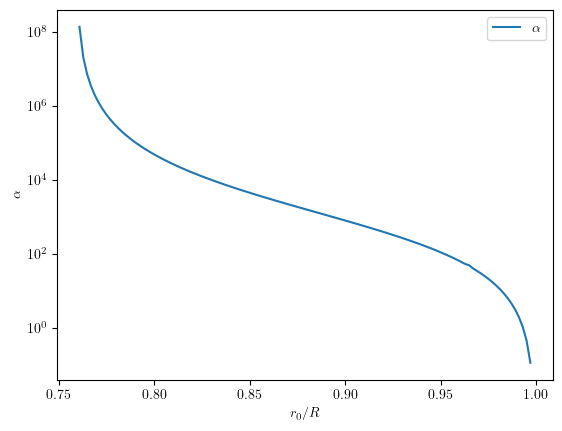

In [12]:
plt.plot(normr0grid,alphagrid,label=r'$\alpha$')
plt.xlabel(r'$r_0 / R$')
plt.ylabel(r'$\alpha$')
# plt.vlines(1,alphagrid.min(),alphagrid.max(),colors='r',label="Horizon")
plt.semilogy()
plt.legend()
# plt.xlim((1.25,2))
plt.show()

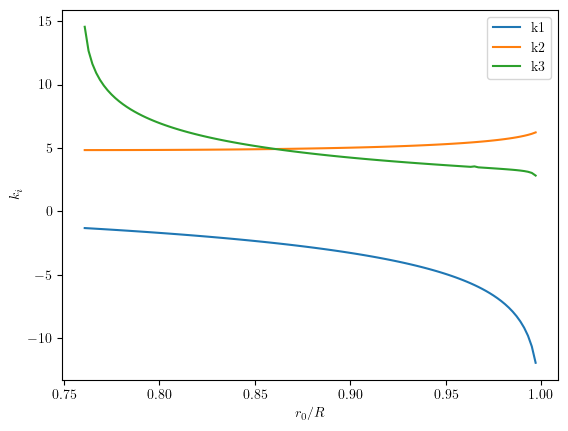

In [13]:
plt.plot(normr0grid,k1grid,label='k1')
plt.plot(normr0grid,k2grid,label='k2')
plt.plot(normr0grid,k3grid,label='k3')
plt.xlabel(r'$r_0 / R$')
plt.ylabel(r'$k_i$')
plt.legend()
# plt.semilogx()
# plt.semilogy()
plt.show()

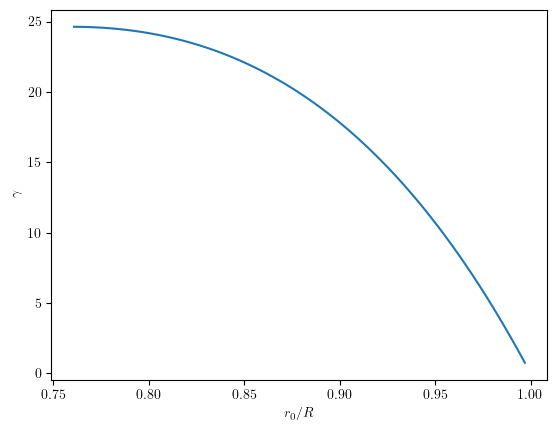

In [14]:
plt.plot(normr0grid,gamma2(r0grid,R))
plt.xlabel(r'$r_0/R$')
plt.ylabel(r'$\gamma$')
plt.show()


In [15]:
# def det(rgrid,R):
#     # rough estimate of r_crit in EQ 40 of 1405.7365
#     eqgrid = fp(rgrid,R)*rgrid+(2*d-4)*f(rgrid,R)
#     # print(f'eqgrid: {eqgrid}')
#     # print(f'abseqgrid: {np.abs(eqgrid)}')
#     minloc = np.argmin(np.abs(eqgrid))
#     return eqgrid[minloc],rgrid[minloc]

# det(np.linspace(0.001,R,1000000),R)

In [16]:
# this is not consistent with what the paper expects, huh
#  time to calculate some area i guess

In [17]:
def AInteg(rgrid,r0,R):
    return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))

def divArea(rgrid,R):
    return (rgrid**(d-2)) / np.sqrt(f(rgrid,R))

def SAdeterm(r,r0,R):
    return f(r,R) + gamma2(r0,R)*(r**(4-2*d))

In [18]:
def shockArea(r0grid,R):
    areaList = []
    area1List = [] # this guy and below are for debug
    area2List = []
    rgrid1 = np.logspace(np.log10(R+0.1),np.log10(rmax-1),num)
    divAreaInteg = divArea(rgrid1,R)
    for i in range(len(r0grid)):
        r0 = r0grid[i]
        bigrgrid2 = np.linspace(r0,R-0.1,num)
        detmask = SAdeterm(bigrgrid2,r0,R) > 0.0001
        if len(bigrgrid2[detmask]) >= (len(bigrgrid2)-1):
            bigrmin, bigrmax = bigrgrid2[detmask].min(), bigrgrid2[detmask].max()
            rgrid2 =  np.linspace(bigrmin,bigrmax,num)
            areaInteg1 = AInteg(rgrid1,r0,R) - divAreaInteg
            area1 = np.trapezoid(areaInteg1,rgrid1)
            areaInteg2 = AInteg(rgrid2,r0,R)
            mask = np.isfinite(areaInteg2)
            area2 = np.trapezoid(areaInteg2[mask],rgrid2[mask])
            areaSum = (2 * area1) + (4 * area2)
            areaList.append(areaSum)
            area1List.append(area1)
            area2List.append(area2)
        else:
            areaList.append(0)
            area1List.append(0)
            area2List.append(0)
    return np.array(areaList) # , area1List, area2List

In [19]:
areaInt = shockArea(r0grid,R)

In [20]:
# # lets filter this data i guess
# for i in range(len(areaInt)):
#     if ((areaInt[i] - areaInt[i-1]) > 10**3):
#         areaInt[i] = (areaInt[i+1]+areaInt[i-1])/2

# # for i in range(len(areaInt)):
# #     if (areaInt[i] > 10**3):
# #         areaInt[i] = (areaInt[i+1]+areaInt[i-1])/2

In [21]:
saplotmask = areaInt > 0

Text(0, 0.5, 'shocked area')

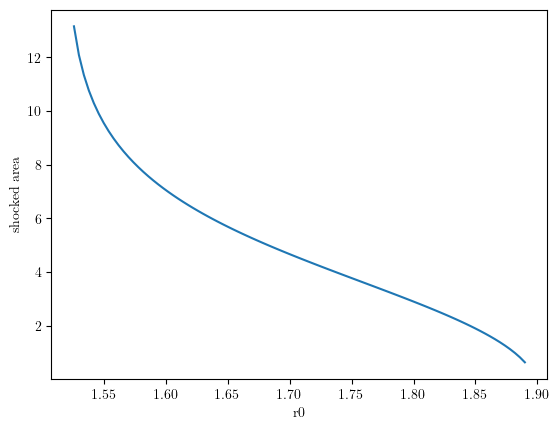

In [22]:
plt.plot(r0grid[saplotmask],areaInt[saplotmask])
plt.xlabel('r0')
plt.ylabel('shocked area')
# plt.semilogy()

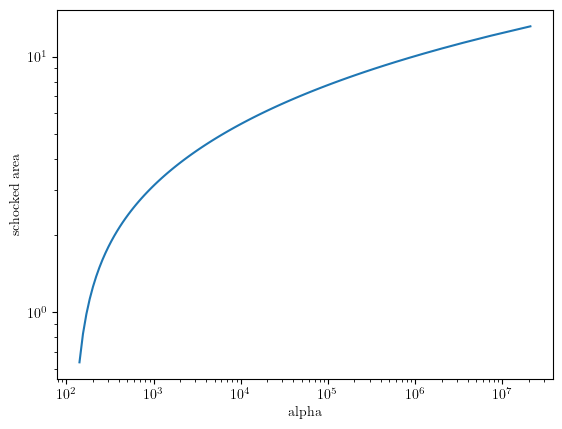

In [23]:
plt.plot(alphagrid[saplotmask],areaInt[saplotmask])
plt.xlabel('alpha')
plt.ylabel('schocked area')
plt.semilogy()
plt.semilogx()
plt.show()

In [24]:
# lets relate L and rmin so we can find critical length scales later, equation 11
def Lvsrmin(rminarr,R):
    Larr = []
    for rmin in rminarr:
        rarr = np.logspace(np.log10(rmin+0.1),np.log10(rmax-1),num)
        integ = 2*l/(rarr*np.sqrt(f(rarr,R)*((rarr/rmin)**(2*d-2))-f(rarr,R)))
        L = np.trapezoid(integ,rarr)
        if np.isfinite(L):
            Larr.append(L)
        else:
            Larr.append(0)
    return np.array(Larr)

In [25]:
# now lets do the areas of unshocked regions, this area functional comes from EQ 12
# these unshocked areas are gonna be ultimately dependent on the strip width for like real params, but for now we can just punch in rmin
def unAreaInt(rminarr,R): # area for one unbroken surface
    arealist = []
    for rmin in rminarr:
        r = np.logspace(np.log10(rmin+1),np.log10(rmax-1),num)
        integ = 2 * (r**(d-2))/np.sqrt(f(r,R)-f(r,R)*(((rmin-0.01)/r)**(2*d-2)))
        divInteg = 2 * (r**(d-2))/np.sqrt(f(r,R))
        newint = integ-divInteg
        area = np.trapezoid(newint,r)
        arealist.append(area)
    return np.array(arealist)

In [26]:
rminarr = np.logspace(np.log10(R+0.1),np.log10(rmax-1),num)

In [27]:
LvsrminArr = Lvsrmin(rminarr,R)

/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_82996/1961872960.py:6: RuntimeWarning: divide by zero encountered in divide
  integ = 2*l/(rarr*np.sqrt(f(rarr,R)*((rarr/rmin)**(2*d-2))-f(rarr,R)))


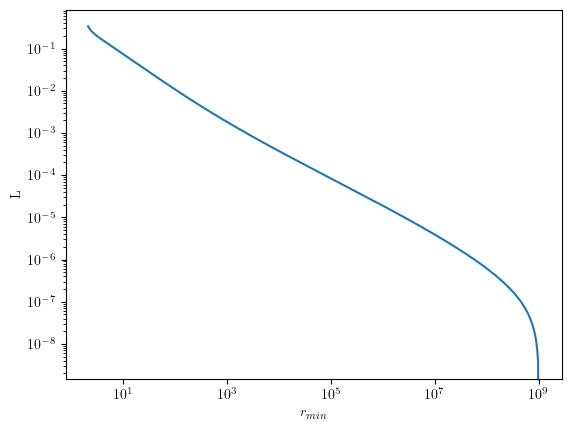

In [28]:
plt.plot(rminarr,LvsrminArr)
plt.semilogx()
plt.semilogy()
plt.xlabel(r'$r_{min}$')
plt.ylabel(r'L')
plt.show()

In [29]:
unArea = unAreaInt(rminarr,R)

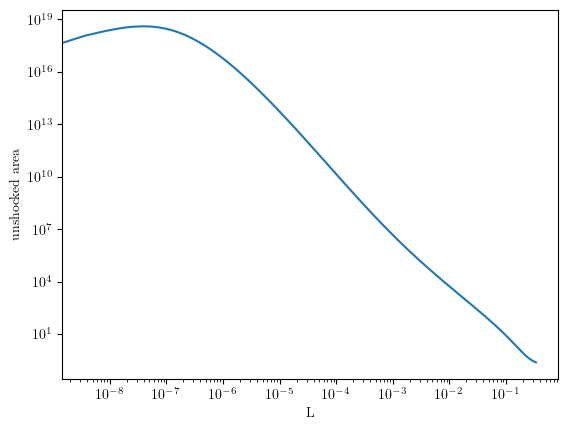

In [30]:
plt.plot(LvsrminArr,unArea)
plt.xlabel("L")
plt.ylabel("unshocked area")
plt.semilogx()
plt.semilogy()
plt.show()

In [31]:
len(unArea)

500

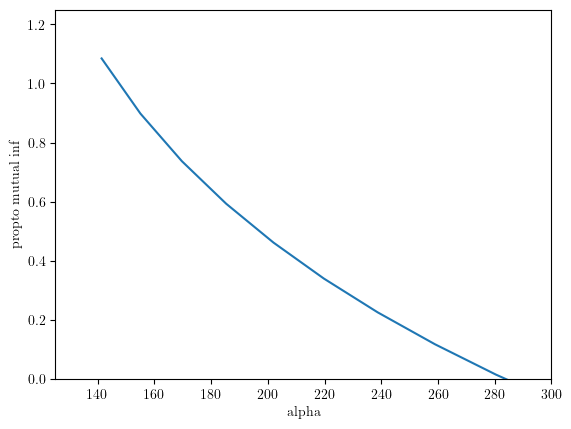

In [32]:
plt.plot(alphagrid[saplotmask],(2*unArea[10]-areaInt[saplotmask]))
plt.xlabel("alpha")
plt.ylabel("propto mutual inf")
# plt.semilogx()
# plt.semilogy()
plt.ylim((0,1.25))
plt.xlim((125,300))
plt.show()

In [33]:
np.argmin(np.abs(2*unArea[-2]-areaInt),0)

np.int64(0)

In [34]:
# ok i have no idea what to expect from this jawn
# i guess we could plot like the Lcrit vs alpha in the flavor of figure 1?

In [35]:
def LCritFunc(Lgrid,alphagrid,unShockGrid,shockGrid):
    Lcritarr = []
    for i in range(len(alphagrid)):
        shockArea = shockGrid[i]
        mutinfGrid = 2 * unShockGrid - shockArea
        mutinfInterp = sp.interpolate.interp1d(mutinfGrid,Lgrid,fill_value="extrapolate")
        Lcrit = mutinfInterp(0)
        Lcritarr.append(Lcrit)
    return np.array(Lcritarr)
        


In [36]:
LCvsalpha = LCritFunc(LvsrminArr,alphagrid,unArea,areaInt)

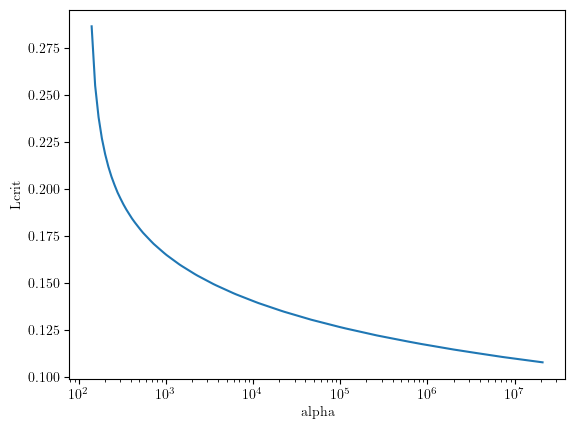

In [37]:
plt.plot(alphagrid[saplotmask],LCvsalpha[saplotmask])
plt.xlabel('alpha')
plt.ylabel('Lcrit')
# plt.semilogy()
plt.semilogx()
plt.show()

In [38]:
# # oh god its broken lets fix it
# Lcritarr = []
# for i in range(len(alphagrid)):
#     alpha = alphagrid[i]
#     # print(alpha)
#     shockArea = areaInt[i]
#     # print(shockArea)
#     mutinfGrid = 2 * unArea - shockArea
#     with open('mutinfgrid.txt','a') as f:
#         print(f'\n {mutinfGrid}',file=f)
#     mutinfInterp = sp.interpolate.interp1d(mutinfGrid,LvsrminArr,fill_value="extrapolate")
#     Lcrit = mutinfInterp(0)
#     print(Lcrit)
#     # critIdx = np.argmin(np.abs(mutinfGrid)) # this precision sucks, a better way to do in future is interpolate but im not troubleshooting that rn

#     # print(critIdx)
#     # Lcrit = LvsrminArr[critIdx]
#     # print(Lcrit)
#     Lcritarr.append(Lcrit)
# Lcritarr = np.array(Lcritarr)

In [39]:
# lets make some big functions that work at different temperatures to put in the big boy python script

In [40]:
def genAlphaPlot(Rmin,Rmax,Rnum,Rtyp='lin'):
    if Rtyp == 'lin':
        Rgrid = np.linspace(Rmin,Rmax,Rnum)
    elif Rtyp == 'log':
        Rgrid = np.logspace(np.log10(Rmin),np.log10(Rmax),Rnum)
    else:
        print('Invalid Rtyp, use lin or log')
        return 0
    
    for R in Rgrid:
        r0grid = np.linspace(r0min,0.999*R,num)
        alphagrid = alpha(r0grid,R)
        mask = k3(r0grid,R) > 0
        plt.plot(r0grid[mask],alphagrid[mask],label=f'R = {R:.3f}')

    plt.xlabel(r'$r_0$')
    plt.ylabel(r'$\alpha$')
    # plt.vlines(R,alphagrid.min(),alphagrid.max(),colors='r',label="Horizon")
    plt.semilogy()
    plt.legend()
    plt.show()

    # for plotting of k functions at different temperatures, uncomment. makes many a plot, not reccommended
    # k1grid = k1(r0grid,R)
    # k2grid = k2(r0grid,R)
    # k3grid = k3(r0grid,R)

    # plt.plot(r0grid,k1grid,label='k1')
    # plt.plot(r0grid,k2grid,label='k2')
    # plt.plot(r0grid,k3grid,label='k3')
    # plt.xlabel('r0')
    # plt.ylabel('k_i')
    # plt.legend()
    # # plt.semilogx()
    # plt.semilogy()
    # plt.show()

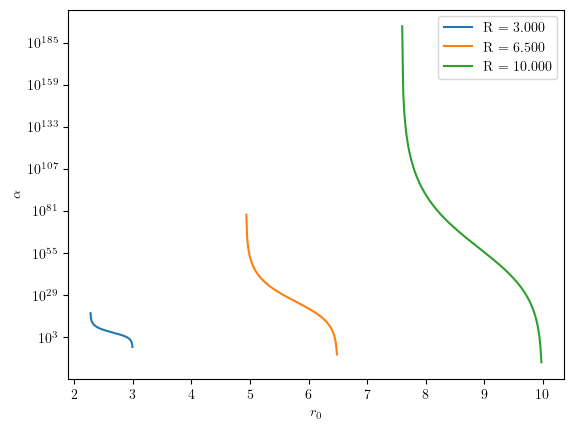

In [41]:
genAlphaPlot(3,10,3,'lin')

In [42]:
def genShockPlot(Rmin,Rmax,Rnum,Rtyp='lin'):
    if Rtyp == 'lin':
        Rgrid = np.linspace(Rmin,Rmax,Rnum)
    elif Rtyp == 'log':
        Rgrid = np.logspace(np.log10(Rmin),np.log10(Rmax),Rnum)
    else:
        print('Invalid Rtyp, use lin or log')
        return 0
    
    for R in Rgrid:
        r0grid = np.logspace(np.log10(r0min),np.log10(0.999*R),num)
        alphagrid = alpha(r0grid,R)
        areaInt = shockArea(r0grid,R)
        mask = areaInt > 0
        plt.plot(alphagrid[mask],areaInt[mask],label=f'R = {R:.3f}')
    
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'Area$_{A \cup B}$')
    plt.legend()
    plt.semilogx()
    plt.semilogy()
    plt.show()

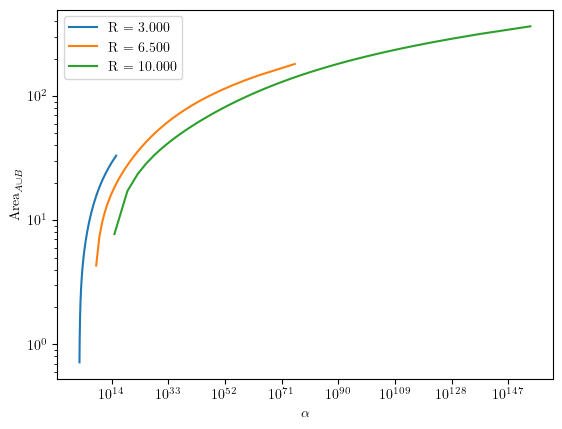

In [43]:
genShockPlot(3,10,3)

In [44]:
def genLvsrminPlot(Rmin,Rmax,Rnum,Rtyp='lin',rminmax=rmax):
    if Rtyp == 'lin':
        Rgrid = np.linspace(Rmin,Rmax,Rnum)
    elif Rtyp == 'log':
        Rgrid = np.logspace(np.log10(Rmin),np.log10(Rmax),Rnum)
    else:
        print('Invalid Rtyp, use lin or log')
        return 0
    
    for  R in Rgrid:
        rminarr = np.logspace(np.log10(R+0.1),np.log10(rmax-1),num)
        LvsrminArr = Lvsrmin(rminarr,R)
        plt.plot(rminarr,LvsrminArr,label=f'R = {R:.3f}')
    
    plt.xlabel(r'$r_{min}$')
    plt.ylabel(r'$L$')
    plt.xlim((2,rminmax))
    plt.legend()
    plt.semilogx()
    # plt.semilogy()
    plt.show()

/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_82996/1961872960.py:6: RuntimeWarning: divide by zero encountered in divide
  integ = 2*l/(rarr*np.sqrt(f(rarr,R)*((rarr/rmin)**(2*d-2))-f(rarr,R)))


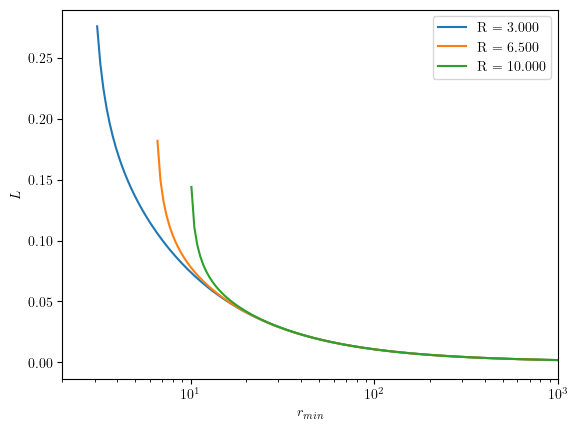

In [45]:
genLvsrminPlot(3,10,3,'lin',1000)

In [46]:
def genUnAreaPlot(Rmin,Rmax,Rnum,Rtyp='lin'):
    if Rtyp == 'lin':
        Rgrid = np.linspace(Rmin,Rmax,Rnum)
    elif Rtyp == 'log':
        Rgrid = np.logspace(np.log10(Rmin),np.log10(Rmax),Rnum)
    else:
        print('Invalid Rtyp, use lin or log')
        return 0
    
    for  R in Rgrid:
        rminarr = np.logspace(np.log10(R+0.1),np.log10(rmax-1),num)
        LArr = Lvsrmin(rminarr,R)
        unArea = unAreaInt(rminarr,R)
        plt.plot(LArr,unArea,label=f'R = {R:.3f}')
    
    plt.xlabel(r'$L$')
    plt.ylabel(r'Area$_{A}$')
    plt.semilogx()
    plt.semilogy()
    plt.legend()
    plt.show()

/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_82996/1961872960.py:6: RuntimeWarning: divide by zero encountered in divide
  integ = 2*l/(rarr*np.sqrt(f(rarr,R)*((rarr/rmin)**(2*d-2))-f(rarr,R)))


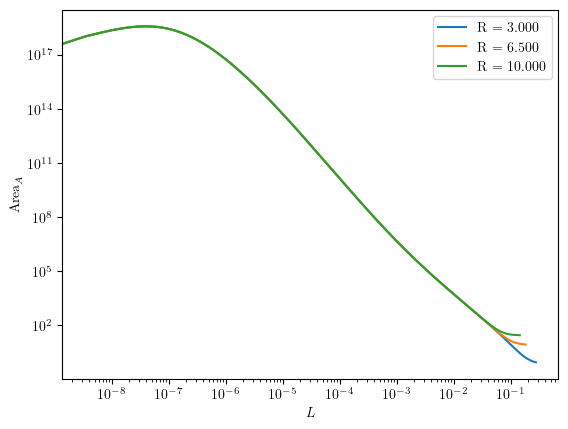

In [47]:
genUnAreaPlot(3,10,3)

In [48]:
def genMutInfPlot(Rmin,Rmax,Rnum,Rtyp='lin',Lidx=(num/2)):
    # can only give general shape of mutual information, as the "y" location is determined by the width of regions A and B
    # we will just pick a random index for now as default
    if Rtyp == 'lin':
        Rgrid = np.linspace(Rmin,Rmax,Rnum)
    elif Rtyp == 'log':
        Rgrid = np.logspace(np.log10(Rmin),np.log10(Rmax),Rnum)
    else:
        print('Invalid Rtyp, use lin or log')
        return 0
    
    maxval = 0
    xmax = 0
    xmin = np.inf

    Lidx = np.array(int(Lidx))

    for R in Rgrid:
        r0grid = np.logspace(np.log10(r0min),np.log10(0.999*R),num)
        rminarr = np.logspace(np.log10(R+0.1),np.log10(rmax-1),num)
        alphagrid = alpha(r0grid,R)
        unArea = unAreaInt(rminarr,R)
        areaInt = shockArea(r0grid,R)
        mask = areaInt>0
        mutInf = 2*unArea[Lidx] - areaInt
        plt.plot(alphagrid[mask],mutInf[mask],label=f'R = {R:.3f}')
        
        if mutInf[mask].max() > maxval:
            maxval = mutInf[mask].max()
        if alphagrid[np.argmin(np.abs(mutInf))] > xmax:
            xmax = alphagrid[np.argmin(np.abs(mutInf))]
        if alphagrid[mask].min() < xmin:
            xmin = alphagrid[mask].min()

    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\propto I(A,B)$')
    plt.ylim((0,maxval))
    plt.xlim((xmin,xmax))
    plt.legend()
    plt.semilogx()
    # plt.semilogy()
    plt.show()

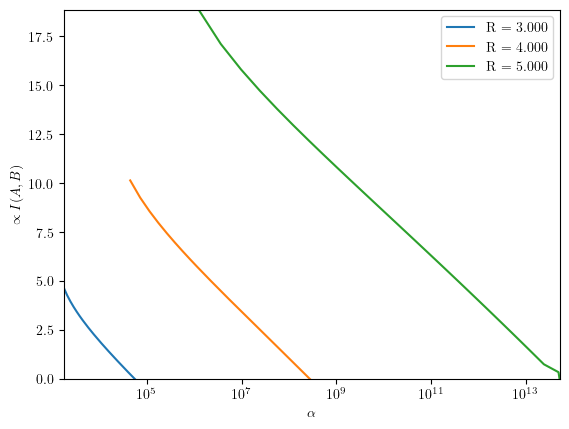

In [49]:
genMutInfPlot(3,5,3,'lin',10)

In [52]:
def genLCritPlot(Rmin,Rmax,Rnum,Rtyp='lin'):
    if Rtyp == 'lin':
        Rgrid = np.linspace(Rmin,Rmax,Rnum)
    elif Rtyp == 'log':
        Rgrid = np.logspace(np.log10(Rmin),np.log10(Rmax),Rnum)
    else:
        print('Invalid Rtyp, use lin or log')
        return 0

    for R in Rgrid:
        r0grid = np.logspace(np.log10(r0min),np.log10(0.999*R),num)
        rminarr = np.logspace(np.log10(R+0.1),np.log10(rmax-1),num)
        LArr = Lvsrmin(rminarr,R)
        alphagrid = alpha(r0grid,R)
        # print(len(alphagrid))
        k3grid = k3(r0grid,R)
        alphamask = k3grid > 0.1
        r0grid = r0grid[alphamask]
        alphagrid = alphagrid[alphamask]
        # print(len(alphagrid))
        unArea = unAreaInt(rminarr,R)
        areaInt = shockArea(r0grid,R)
        # print(len(areaInt))
        mask = areaInt > 0
        areaInt = areaInt[mask]
        alphagrid = alphagrid[mask]
        LCArr = LCritFunc(LArr,alphagrid,unArea,areaInt)
        
        # lets mask off more flat bits
        diff = np.diff(LCArr)
        flatmask = diff > 0
        # print(flatmask)
        flatmask = np.append(flatmask,False)
        plt.plot(alphagrid[flatmask],LCArr[flatmask],label=f'R = {R:.3f}')
    
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$L_{crit.}$')
    plt.legend()
    plt.semilogx()
    # plt.semilogy()
    # plt.xlim((0.1,100))
    plt.show()

/var/folders/sf/wr1kbwcd5dj1bbcsxb86lz7w0000gn/T/ipykernel_82996/1961872960.py:6: RuntimeWarning: divide by zero encountered in divide
  integ = 2*l/(rarr*np.sqrt(f(rarr,R)*((rarr/rmin)**(2*d-2))-f(rarr,R)))


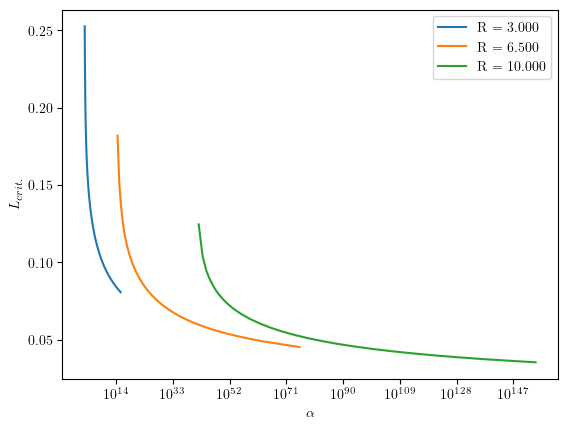

In [53]:
genLCritPlot(3,10,3)